# 15 minute city - test

In [1]:
import os
import sys

import pandas as pd
import geopandas as gpd
import osmnx as ox

import matplotlib.pyplot as plt

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

module_path = os.path.abspath(os.path.join('../../'))
if module_path not in sys.path:
    sys.path.append(module_path)
    import aup

/home/edgaregurrola/.local/lib/python3.10/site-packages/osmnx/utils.py:192: UserWarning: The `utils.config` function is deprecated and will be removed in a future release. Instead, use the `settings` module directly to configure a global setting's value. For example, `ox.settings.log_console=True`.
  warnings.warn(


## Download data from database

In [2]:
year = 2020

#Folder names from database
schema = 'prox_analysis'
hex_folder = 'hex_bins_proximity_2020'

res = 8
c = 'Guadalajara'

In [3]:
query = f"SELECT * FROM {schema}.{hex_folder} WHERE \"metropolis\" LIKE \'{c}\'"
hex_bins = aup.gdf_from_query(query, geometry_col='geometry')

In [4]:
print(hex_bins.shape)
hex_bins.head(2)

(163800, 5)


,hex_id_8,geometry,time,amenity,metropolis
0,8849ab5349fffff,"POLYGON ((-103.60744 20.46531, -103.60689 20.4...",105.894193,clues_primer_nivel,Guadalajara
1,8849abc91bfffff,"POLYGON ((-103.60989 20.39686, -103.61044 20.4...",0.000000,clues_primer_nivel,Guadalajara


## Data treatment

### Filter hexagons without data

In [5]:
idx = hex_bins['time']>0
hex_bins = hex_bins.loc[idx]

### Remove duplicate hexagons

In [6]:
hex_bins_geom = hex_bins.drop_duplicates(subset='hex_id_8', keep="last")[['hex_id_8','geometry','metropolis']].copy()
print(hex_bins_geom.shape)
hex_bins_geom.head(2)

(2993, 3)


,hex_id_8,geometry,metropolis
159439,8849abc991fffff,"POLYGON ((-103.64983 20.45329, -103.64928 20.4...",Guadalajara
159440,8849abc947fffff,"POLYGON ((-103.58795 20.37278, -103.58740 20.3...",Guadalajara


### Rows to columns

In [7]:
hex_bins_analysis = hex_bins_geom.copy()

for amenidad in list(hex_bins.amenity.unique()):
    hex_tmp = hex_bins.loc[hex_bins.amenity == amenidad,['hex_id_8','time']]
    hex_tmp = hex_tmp.rename(columns={'time':amenidad})
    hex_bins_analysis = hex_bins_analysis.merge(hex_tmp, on='hex_id_8')
    
print(hex_bins_analysis.shape)
hex_bins_analysis.head(2)

(2992, 42)


,hex_id_8,geometry,metropolis,clues_primer_nivel,clues_segundo_nivel,clues_tercer_nivel,sip_centro_admin,denue_preescolar,denue_primaria,denue_secundaria,...,denue_libros,denue_revistas_periodicos,denue_ferreteria_tlapaleria,denue_art_limpieza,denue_pintura,denue_peluqueria,sip_cancha,sip_unidad_deportiva,sip_espacio_publico,sip_mercado
0,8849abc991fffff,"POLYGON ((-103.64983 20.45329, -103.64928 20.4...",Guadalajara,44.468490,352.417328,768.225946,44.479238,39.640466,45.376206,111.020650,...,438.982212,460.704094,38.475937,44.841704,366.887381,37.125012,76.359356,42.160455,46.016838,44.513087
1,8849abc947fffff,"POLYGON ((-103.58795 20.37278, -103.58740 20.3...",Guadalajara,97.652447,343.242848,758.434779,101.806418,97.652447,97.652447,117.527971,...,429.807731,450.912926,92.176562,93.883033,357.712901,93.662124,87.181176,94.595394,83.453921,101.806418


<AxesSubplot:>

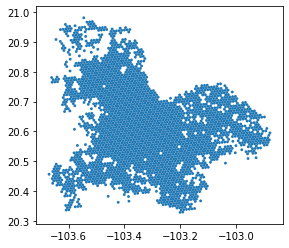

In [8]:
hex_bins_analysis.plot()

## 15 minute analysis

### Parameters definitions

In [9]:
idx_15_min = {'Escuelas':{'Preescolar':['denue_preescolar'],
                         'Primaria':['denue_primaria'],
                         'Secundaria':['denue_secundaria']},
             'Servicios comunitarios':{'Salud':['clues_primer_nivel'],
                                      'Gobierno':['sip_centro_admin'],
                                      'Cuidado':['denue_guarderias','denue_casa_adultos_mayores',
                                                'denue_dif']},
              'Comercio':{'Básicos':['denue_supermercado','denue_abarrotes',
                                    'denue_carnicerias','sip_mercado'],
                         'Personal':['denue_peluqueria','denue_farmacias'],
                         'Hogar':['denue_ferreteria_tlapaleria','denue_art_limpieza'],
                         'Complementarios':['denue_ropa','denue_calzado','denue_muebles',
                                           'denue_lavanderia','denue_revistas_periodicos',
                                           'denue_pintura']},
              'Entretenimiento':{'Social':['denue_restaurante_insitu','denue_restaurante_llevar',
                                          'denue_bares','denue_cafe'],
                                'Actividad física':['sip_cancha','sip_unidad_deportiva',
                                                   'sip_espacio_publico','denue_parque_natural'],
                                'Cultural':['denue_cines','denue_museos']} 
             }

wegiht_idx = {'Escuelas':{'Preescolar':1,
                         'Primaria':1,
                         'Secundaria':1},
             'Servicios comunitarios':{'Salud':1,
                                      'Gobierno':1,
                                      'Cuidado':1},
              'Comercio':{'Básicos':1,
                         'Personal':1,
                         'Hogar':1,
                         'Complementarios':1},
              'Entretenimiento':{'Social':1,
                                'Actividad física':1,
                                'Cultural':1}
             }

tiempos_15_min = {'denue_preescolar':[5,'peatonal'],
                 'denue_primaria':[5,'peatonal'],
                 'denue_secundaria':[15,'peatonal'],
                  'denue_escuela_mixta':[15,'peatonal'],
                 'clues_primer_nivel':[5,'peatonal'],
                 'sip_centro_admin':[15,'bicicleta'],
                 'denue_guarderias':[10,'peatonal'],
                 'denue_casa_adultos_mayores':[5,'peatonal'],
                 'denue_dif':[15,'bicicleta'],
                 'denue_supermercado':[5,'peatonal'],
                 'denue_abarrotes':[5,'peatonal'],
                 'denue_carnicerias':[5,'peatonal'],
                 'sip_mercado':[5,'peatonal'],
                 'denue_peluqueria':[15,'bicicleta'],
                  'denue_farmacias':[15,'peatonal'],
                  'denue_ferreteria_tlapaleria':[15,'peatonal'],
                  'denue_art_limpieza':[15,'peatonal'],
                  'denue_ropa':[15,'peatonal'],
                  'denue_calzado':[15,'peatonal'],
                  'denue_muebles':[15,'peatonal'],
                  'denue_lavanderia':[15,'peatonal'],
                  'denue_revistas_periodicos':[15,'peatonal'],
                  'denue_pintura':[15,'peatonal'],
                  'denue_restaurante_insitu':[15,'peatonal'],
                  'denue_restaurante_llevar':[15,'peatonal'],
                  'denue_bares':[15,'peatonal'],
                  'denue_cafe':[15,'peatonal'],
                  'sip_cancha':[5,'peatonal'],
                  'sip_unidad_deportiva':[5,'peatonal'],
                  'sip_espacio_publico':[5,'peatonal'],
                  'denue_parque_natural':[15,'bicicleta'],
                  'denue_cines':[15,'bicicleta'],
                  'denue_museos':[15,'bicicleta']
                 }

### Analysis

In [20]:
# create gdf for analysis
hex_15_min = hex_bins_analysis.copy()

# determines whether a certain amenity is within the limit time 
for amenidad in list(tiempos_15_min.keys()):
    # creates column to save whether a amenity is within the limit time
    idx_column_name = 'idx' + amenidad[amenidad.find('_'):]
    hex_15_min[idx_column_name] = 0
    
    if tiempos_15_min[amenidad][1] == 'peatonal':
        tiempo_limite = tiempos_15_min[amenidad][0]
    else:
        tiempo_limite = tiempos_15_min[amenidad][0] * 3
        
    idx_amenidad = hex_15_min[amenidad] <= tiempo_limite
    hex_15_min.loc[idx_amenidad, idx_column_name] = 1
    
    dif_time_column = 'time_dif_' + amenidad[amenidad.find('_'):]
    hex_15_min[dif_time_column] = hex_15_min[amenidad].apply(lambda x: x - tiempo_limite)
    idx_tiempo = hex_15_min[dif_time_column] <= 0
    hex_15_min.loc[idx_tiempo, dif_time_column] = 0
    
    

In [21]:
cat_list = []
raw_cat_list = []
time_cat_list = []
meantime_cat_list = []

for cat in idx_15_min.keys():
    
    cat_list.append(cat)
    raw_cat_list.append('raw_'+cat)
    time_cat_list.append('time_dif_'+cat)
    meantime_cat_list.append('meantime_dif_'+cat)
    
    subcat_list = []
    raw_subcat_list = []
    time_subcat_list = []
    meantime_subcat_list = []
    
    for subcat in idx_15_min[cat]:
        
        subcat_list.append(subcat)
        raw_subcat_list.append('raw_'+subcat)
        time_subcat_list.append('time_dif_'+subcat)
        meantime_subcat_list.append('meantime_dif_'+subcat)
                
        subcat_amenities_list = []
        time_subcat_amenities_list = []
        
        for amenidad in idx_15_min[cat][subcat]:
            
            idx_column_name = 'idx' + amenidad[amenidad.find('_'):]
            subcat_amenities_list.append(idx_column_name)
            dif_time_column = 'time_dif_' + amenidad[amenidad.find('_'):]
            time_subcat_amenities_list.append(dif_time_column)
            
        hex_15_min['raw_'+subcat] = (hex_15_min[subcat_amenities_list].sum(axis=1) / len(subcat_amenities_list)) * wegiht_idx[cat][subcat]
        
        idx = hex_15_min['raw_'+subcat] > 0
        hex_15_min[subcat] = 0
        hex_15_min.loc[idx, subcat] = 1 * wegiht_idx[cat][subcat]
        
        hex_15_min['time_dif_'+subcat] = hex_15_min[time_subcat_amenities_list].sum(axis=1)
        hex_15_min['meantime_dif_'+subcat] = hex_15_min[time_subcat_amenities_list].mean(axis=1)
        
        
        
    hex_15_min[cat] = hex_15_min[subcat_list].sum(axis=1)
    hex_15_min['raw_'+cat] = hex_15_min[raw_subcat_list].sum(axis=1)
    
    hex_15_min['time_dif_'+cat] = hex_15_min[meantime_subcat_list].sum(axis=1)
    hex_15_min['meantime_dif_'+cat] = hex_15_min[meantime_subcat_list].mean(axis=1)
    
hex_15_min['15_min_analysis'] = hex_15_min[cat_list].sum(axis=1)
hex_15_min['raw_15_min_analysis'] = hex_15_min[raw_cat_list].sum(axis=1)
hex_15_min['time_15_min_analysis'] = hex_15_min[time_cat_list].sum(axis=1)
hex_15_min['meantime_15_min_analysis'] = hex_15_min[meantime_cat_list].mean(axis=1)

In [12]:
hex_15_min['15_min_analysis']

0       2
1       0
2       4
3       0
4       0
       ..
2987    0
2988    0
2989    0
2990    0
2991    1
Name: 15_min_analysis, Length: 2992, dtype: int64

(-103.71471496005557,
 -102.83380358956258,
 20.29070243473398,
 21.018919525455594)

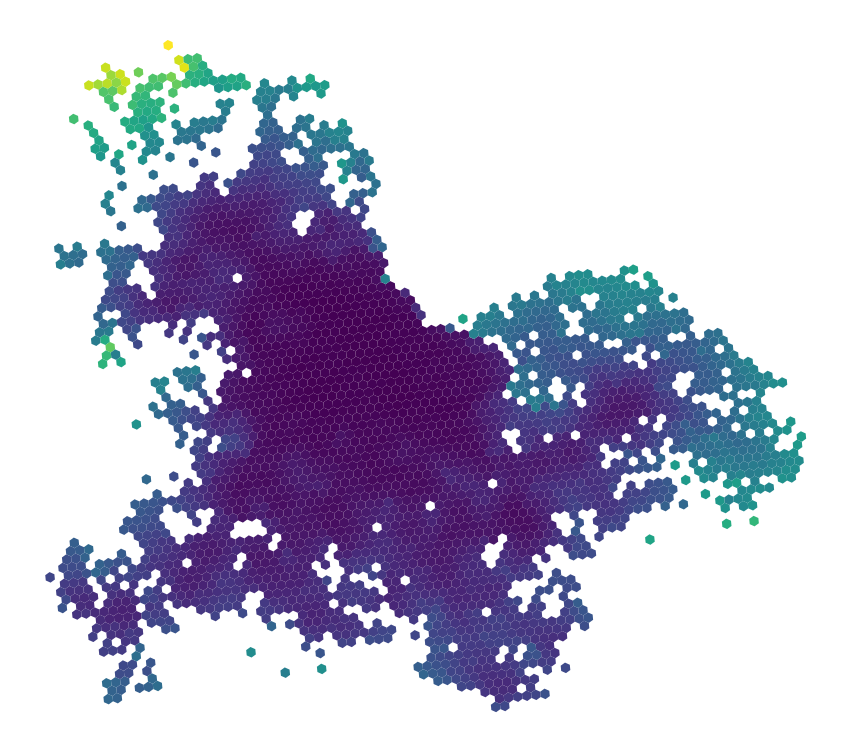

In [22]:
fig, ax = plt.subplots(figsize=(15,15))


hex_15_min.plot('meantime_15_min_analysis',ax=ax)

ax.axis('off')

In [14]:
hex_15_min

,hex_id_8,geometry,metropolis,clues_primer_nivel,clues_segundo_nivel,clues_tercer_nivel,sip_centro_admin,denue_preescolar,denue_primaria,denue_secundaria,...,raw_Social,Social,raw_Actividad física,Actividad física,raw_Cultural,Cultural,Entretenimiento,raw_Entretenimiento,15_min_analysis,raw_15_min_analysis
0,8849abc991fffff,"POLYGON ((-103.64983 20.45329, -103.64928 20.4...",Guadalajara,44.468490,352.417328,768.225946,44.479238,39.640466,45.376206,111.020650,...,0.00,0,0.0,0,0.0,0,0,0.00,2,1.500000
1,8849abc947fffff,"POLYGON ((-103.58795 20.37278, -103.58740 20.3...",Guadalajara,97.652447,343.242848,758.434779,101.806418,97.652447,97.652447,117.527971,...,0.00,0,0.0,0,0.0,0,0,0.00,0,0.000000
2,8849abc9ebfffff,"POLYGON ((-103.61319 20.42802, -103.61772 20.4...",Guadalajara,40.473661,271.638152,687.446771,22.870778,24.705283,23.051588,20.315681,...,0.75,1,0.0,0,0.0,0,1,0.75,4,2.583333
3,8849abc9abfffff,"POLYGON ((-103.61539 20.44879, -103.61484 20.4...",Guadalajara,81.463757,276.256559,692.065178,78.772007,63.023395,60.921167,73.292378,...,0.00,0,0.0,0,0.0,0,0,0.00,0,0.000000
4,8849abc90dfffff,"POLYGON ((-103.58397 20.38103, -103.58342 20.3...",Guadalajara,210.760238,274.613877,680.106400,208.068488,193.825688,191.723461,207.270644,...,0.00,0,0.0,0,0.0,0,0,0.00,0,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2987,88498c826dfffff,"POLYGON ((-103.15389 20.67688, -103.14882 20.6...",Guadalajara,57.956713,197.354716,178.816988,62.459946,180.791135,192.308483,191.537655,...,0.00,0,0.0,0,0.0,0,0,0.00,0,0.000000
2988,88498c9b6bfffff,"POLYGON ((-102.94664 20.59418, -102.94717 20.5...",Guadalajara,91.807489,228.596680,246.836076,98.332169,189.467297,190.093239,214.463560,...,0.00,0,0.0,0,0.0,0,0,0.00,0,0.000000
2989,88498c9b2bfffff,"POLYGON ((-102.94472 20.62319, -102.94978 20.6...",Guadalajara,76.784114,250.323679,268.563075,73.777067,211.194296,211.820238,236.190559,...,0.00,0,0.0,0,0.0,0,0,0.00,0,0.000000
2990,88498c9a55fffff,"POLYGON ((-103.03867 20.59339, -103.03919 20.5...",Guadalajara,86.944545,86.803577,108.542416,85.916015,73.618193,78.813428,104.556774,...,0.00,0,0.0,0,0.0,0,0,0.00,0,0.000000


In [23]:
grl_dir = '/home/edgaregurrola/SIG/ObsCds/Proyectos/Ciudad_15_min/'
hex_15_min.to_file(grl_dir+f'Medio_Urbano/Analisis/{c}_15min_Analisis_res{res}_vTime.geojson', driver='GeoJSON')